In [21]:
%%writefile parallel_spec.py

#import libs
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# generate the signal
t = np.linspace(-20*2*np.pi, 20*2*np.pi, 3**9+6)

y = np.sin(t)*np.exp(-t**2/2/20**2)
y += np.sin(3*t)*np.exp(-(t-5*2*np.pi)**2/2/20**2)
y += np.sin(5.5*t)*np.exp(-(t+10*2*np.pi)**2/2/5**2)
y += np.sin(4*t)*np.exp(-(t-7*2*np.pi)**2/2/10**2) # added 4th wave packet

# windowed Fourier transform (Gabor transform, spectrogram)
def get_specgram(y, t, nwindowsteps=1000):
    perrank = nwindowsteps // size
    window_t_full = np.linspace(-20*2*np.pi, 20*2*np.pi, nwindowsteps)
    window_t = window_t_full[perrank * rank:perrank * (rank+1)]    
    if rank == (size - 1):
        window_t = window_t_full[perrank * rank:]
        
    specgram = np.zeros((len(t), nwindowsteps))
    window_width = 2.0 * 2 * np.pi
   
    for n, w_t in enumerate(window_t):
      window_function = np.exp(-(t - w_t) ** 2 / 2 / window_width ** 2)
      specgram[:, n] = abs(np.fft.fft(y * window_function))

    return specgram

start = MPI.Wtime() 
specgram = get_specgram(y, t, 1000)

# gather the result at the master node
specgram = comm.gather(specgram, root = 0)

end = MPI.Wtime()

if rank == 0:
    print (end - start)


Overwriting parallel_spec.py


In [2]:
import matplotlib.pyplot as plt
import numpy as np
#set params for plot
plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams["font.size"] = 20

In [24]:
exe_time = []
N_processes = np.arange(1,11)
for i in N_processes:
    add = !mpiexec -n {i} python parallel_spec.py
    exe_time.append(float(add[0]))

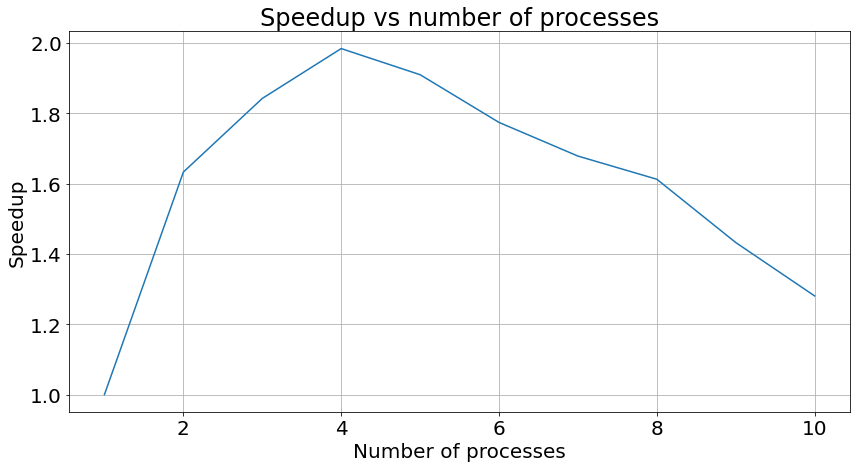

In [25]:
plt.plot(N_processes,  exe_time[0] / np.array(exe_time))
plt.title('Speedup vs number of processes')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)